In [1]:
!pip install --quiet pdetransformer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.7/182.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 828.5/828.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.8/300.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.5/506.5 kB 17.7 MB/s eta 0:00:00


## Initialize PDE-S with pretrained weights from huggingface

In [2]:
from pdetransformer.core.mixed_channels import PDETransformer, SingleStepSupervised
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load pre-trained model
model = PDETransformer.from_pretrained('thuerey-group/pde-transformer', subfolder='mc-s').to(device)

/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/246 [00:00<?, ?B/s]

mc-s/diffusion_pytorch_model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## Load dataset

In [3]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

## Note
Simulation logic below is based on following resource: https://krischer.github.io/seismo_live_build/html/Computational%20Seismology/The%20Finite-Difference%20Method/fd_ac2d_homogeneous_solution.html

# Create Wave Equation Simulator

In [13]:
class WaveEquation2D:
    """2D Wave equation simulator with reflective boundaries."""

    def __init__(self, grid_size=128, domain_size=1.0, c=1.0, dt=0.001):
        self.N = grid_size    # number of grid points in a single direction
        self.L = domain_size  # width and height of domain
        self.c = c            # wave speed
        self.dt = dt          # time step
        self.dx = domain_size / grid_size # grid spatial size

        # CFL condition check
        self.cfl = c * dt / self.dx
        if self.cfl > 1.0 / np.sqrt(2):
            print(f"Warning: CFL condition violated! CFL = {self.cfl:.3f}")
        else:
            print(f"CFL = {self.cfl:.3f} (stable)")

        # State variables
        self.u_curr = np.zeros((grid_size, grid_size))  # Current displacement
        self.u_prev = np.zeros((grid_size, grid_size))  # Previous displacement
        self.time = 0.0

    def initialize_gaussian(self, center=(0.5, 0.5), sigma=0.05, amplitude=1.0):
        x = np.linspace(0, self.L, self.N)
        y = np.linspace(0, self.L, self.N)
        X, Y = np.meshgrid(x, y)

        cx, cy = center
        self.u_curr = amplitude * np.exp(-((X - cx)**2 + (Y - cy)**2) / (2 * sigma**2))
        self.u_prev = self.u_curr.copy()


    def step(self):
        # Laplacian using 5-point stencil
        laplacian = np.zeros_like(self.u_curr)

        # Interior points
        laplacian[1:-1, 1:-1] = (
            self.u_curr[2:, 1:-1] + self.u_curr[:-2, 1:-1] +
            self.u_curr[1:-1, 2:] + self.u_curr[1:-1, :-2] -
            4 * self.u_curr[1:-1, 1:-1]
        ) / (self.dx ** 2)

        # Reflective boundary conditions (Neumann: du/dn = 0)
        # Left and right boundaries
        laplacian[0, :] = laplacian[1, :]
        laplacian[-1, :] = laplacian[-2, :]
        # Top and bottom boundaries
        laplacian[:, 0] = laplacian[:, 1]
        laplacian[:, -1] = laplacian[:, -2]

        # Update using leapfrog scheme
        u_next = 2 * self.u_curr - self.u_prev + (self.c * self.dt) ** 2 * laplacian

        # Update state
        self.u_prev = self.u_curr.copy()
        self.u_curr = u_next
        self.time += self.dt

        return self.u_curr.copy()

    def simulate(self, num_steps):
        trajectory = [self.u_curr.copy()]

        for _ in tqdm(range(num_steps), desc="Simulating wave equation"):
            u = self.step()
            trajectory.append(u)

        return np.array(trajectory)

# Run 2D wave equation ground truth simulation

In [14]:
# Simulation params
GRID_SIZE = 128
DOMAIN_SIZE = 1.0
WAVE_SPEED = 0.5
DT_SIM = 0.001  # Small timestep for accurate simulation
T_TOTAL = 5.0   # Total simulation time
NUM_STEPS = int(T_TOTAL / DT_SIM)

# Create simulator
wave_sim = WaveEquation2D(
    grid_size=GRID_SIZE,
    domain_size=DOMAIN_SIZE,
    c=WAVE_SPEED,
    dt=DT_SIM
)

# Initialize gaussian pulse
wave_sim.initialize_gaussian(center=(0.5, 0.5), sigma=0.08, amplitude=1.0)

# Run sim
gt_trajectory = wave_sim.simulate(NUM_STEPS)
print(f"\nGround truth trajectory shape: {gt_trajectory.shape}")

CFL = 0.064 (stable)


Simulating wave equation: 100%|██████████| 5000/5000 [00:02<00:00, 2414.74it/s]



Ground truth trajectory shape: (5001, 128, 128)


# Plot simulation results to verify

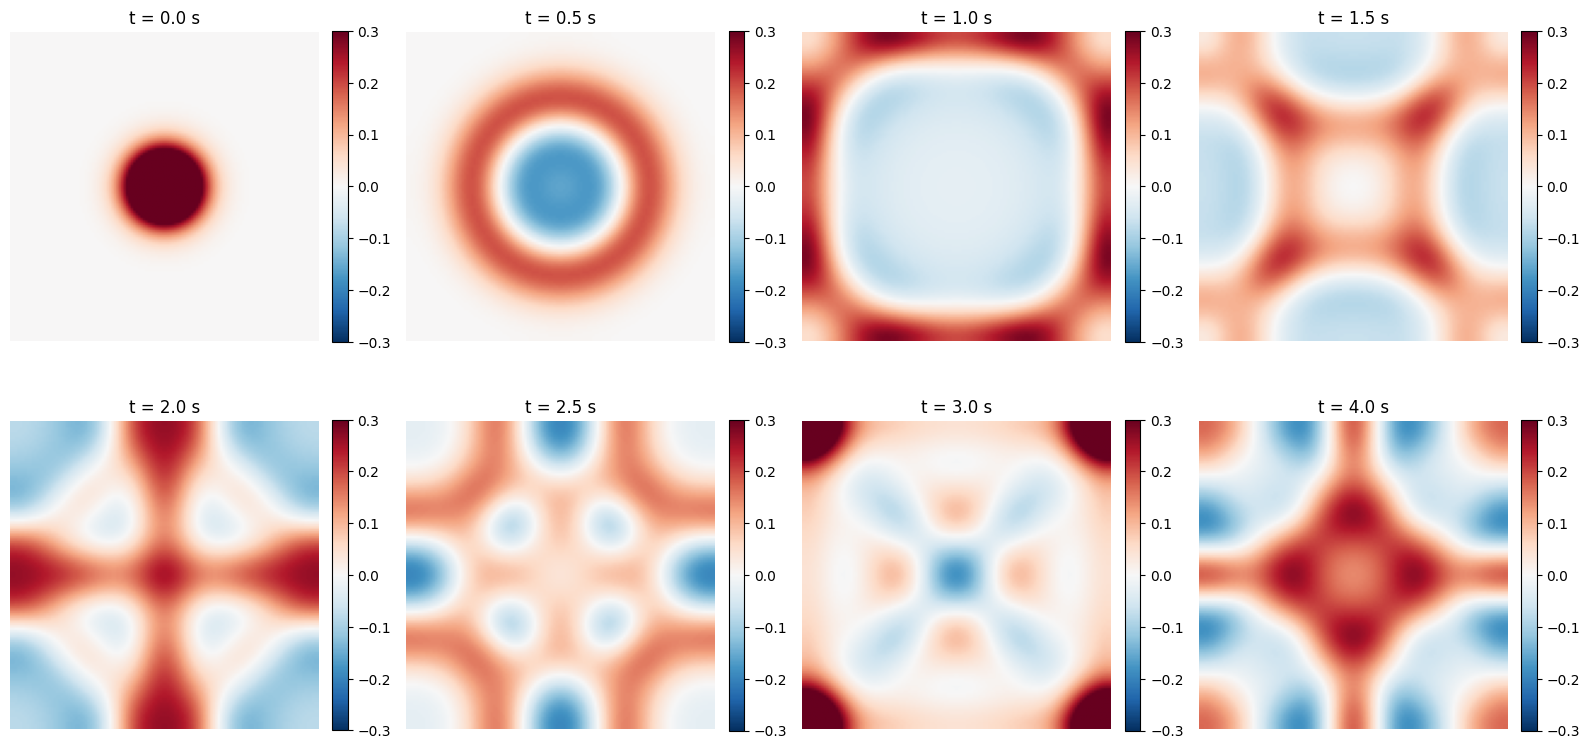

Ground truth wave propagation showing reflections at boundaries


In [15]:
# Plot snapshots at different times
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
times_to_plot = [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0]
vmin, vmax = -0.3, 0.3

for ax, t in zip(axes.flat, times_to_plot):
    idx = int(t / DT_SIM)
    im = ax.imshow(gt_trajectory[idx], cmap='RdBu_r', vmin=vmin, vmax=vmax, origin='lower')
    ax.set_title(f't = {t:.1f} s')
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

print("Ground truth wave propagation showing reflections at boundaries")

# Prepare Data and Perform PDE Transformer Rollout

In [30]:
# Model timestep (larger than simulation timestep)
DT_MODEL = 0.050  # 50 ms per step for the model
SKIP = int(DT_MODEL / DT_SIM)  # How many simulation steps per model step

# Downsample trajectory
gt_downsampled = gt_trajectory[::SKIP]
num_model_steps = len(gt_downsampled) - 2  # -2 because we need 2 frames to start

print(f"Downsampled trajectory shape: {gt_downsampled.shape}")
print(f"Number of model prediction steps: {num_model_steps}")

Downsampled trajectory shape: (101, 128, 128)
Number of model prediction steps: 99


In [31]:
def normalize_data(data):
    # Simple standardization
    mean = np.mean(data)
    std = np.std(data)
    if std > 0:
        return (data - mean) / std, mean, std
    return data, mean, 1.0

def denormalize_data(data, mean, std):
    return data * std + mean

# Normalize the data
gt_normalized, data_mean, data_std = normalize_data(gt_downsampled)

print(f"Data statistics:")
print(f"  Mean: {data_mean:.4f}")
print(f"  Std: {data_std:.4f}")

Data statistics:
  Mean: 0.0409
  Std: 0.0989


# Run PDE Transformer Rollout

In [39]:
@torch.no_grad()
def predict_trajectory_autoregressive(model, initial_frames, num_steps):
    # Initialize predictions as initial frames
    predictions = [initial_frames[0], initial_frames[1]]

    # Current input: last 2 frames
    current_input = torch.from_numpy(initial_frames).float().to(device)
    current_input = current_input.unsqueeze(0)  # Add batch dimension (1, 2, H, W)
    class_labels = torch.ones(current_input.size(1), dtype=torch.long, device=device) * 1000 # no class associated with label 1000

    print(class_labels.shape)
    print(current_input.shape)
    for step in tqdm(range(num_steps), desc="Model predictions"):
        # Predict next frame
        output = model(hidden_states=current_input, class_labels=class_labels)
        # Extract the actual tensor from the output object
        output_tensor = output.sample  # For diffusers models

        # Take the second channel (next timestep prediction)
        next_frame = output_tensor[0, 1].cpu().numpy()
        predictions.append(next_frame)

        # Use last predicted frame and new prediction
        current_input = torch.stack([
            current_input[0, 1],  # Previous second frame becomes first
            output_tensor[0, 1]          # New prediction becomes second
        ]).unsqueeze(0)

    return np.array(predictions)

# Run autoregressive prediction
initial_frames = gt_normalized[:2]
model_predictions = predict_trajectory_autoregressive(
    model,
    initial_frames,
    num_model_steps
)

# Denormalize predictions
model_predictions = denormalize_data(model_predictions, data_mean, data_std)

print(f"Model predictions shape: {model_predictions.shape}")

torch.Size([2])
torch.Size([1, 2, 128, 128])


Model predictions:   0%|          | 0/99 [00:00<?, ?it/s]


RuntimeError: cannot reshape tensor of 0 elements into shape [0, -1, 3, 4, 96] because the unspecified dimension size -1 can be any value and is ambiguous

In [22]:
# calculate MSE per frame and RMSE per frame
mse_per_frame = np.mean((gt_downsampled - model_predictions)**2, axis=(1, 2))
rmse_per_frame = np.sqrt(mse_per_frame)

# Calculate normalized error (NRMSE)
gt_range = np.max(gt_downsampled) - np.min(gt_downsampled)
nrmse_per_frame = rmse_per_frame / gt_range

print(f"Error Statistics:")
print(f"  Mean RMSE: {np.mean(rmse_per_frame):.6f}")
print(f"  Mean NRMSE: {np.mean(nrmse_per_frame):.6f}")
print(f"  Final RMSE: {rmse_per_frame[-1]:.6f}")
print(f"  Final NRMSE: {nrmse_per_frame[-1]:.6f}")

Error Statistics:
  Mean RMSE: 0.258670
  Mean NRMSE: 0.193822
  Final RMSE: 0.241850
  Final NRMSE: 0.181219


# Plot Error Over Time

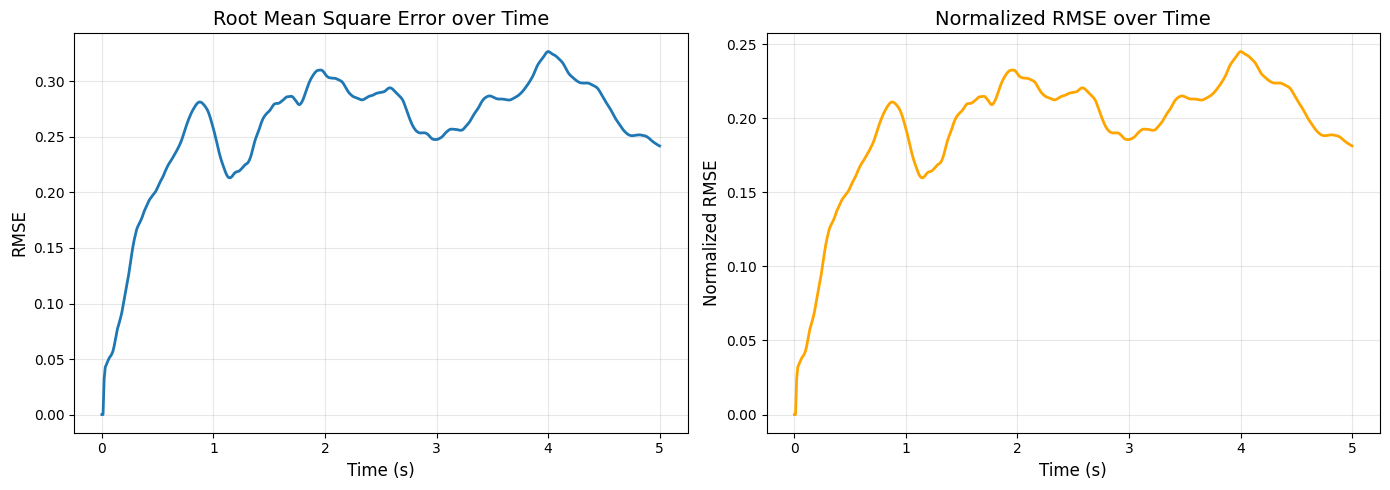

In [23]:
# Plot error as a function of time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

time_array = np.arange(len(mse_per_frame)) * DT_MODEL

ax1.plot(time_array, rmse_per_frame, linewidth=2)
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('RMSE', fontsize=12)
ax1.set_title('Root Mean Square Error over Time', fontsize=14)
ax1.grid(True, alpha=0.3)

ax2.plot(time_array, nrmse_per_frame, linewidth=2, color='orange')
ax2.set_xlabel('Time (s)', fontsize=12)
ax2.set_ylabel('Normalized RMSE', fontsize=12)
ax2.set_title('Normalized RMSE over Time', fontsize=14)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot ground truth vs transformer rollout

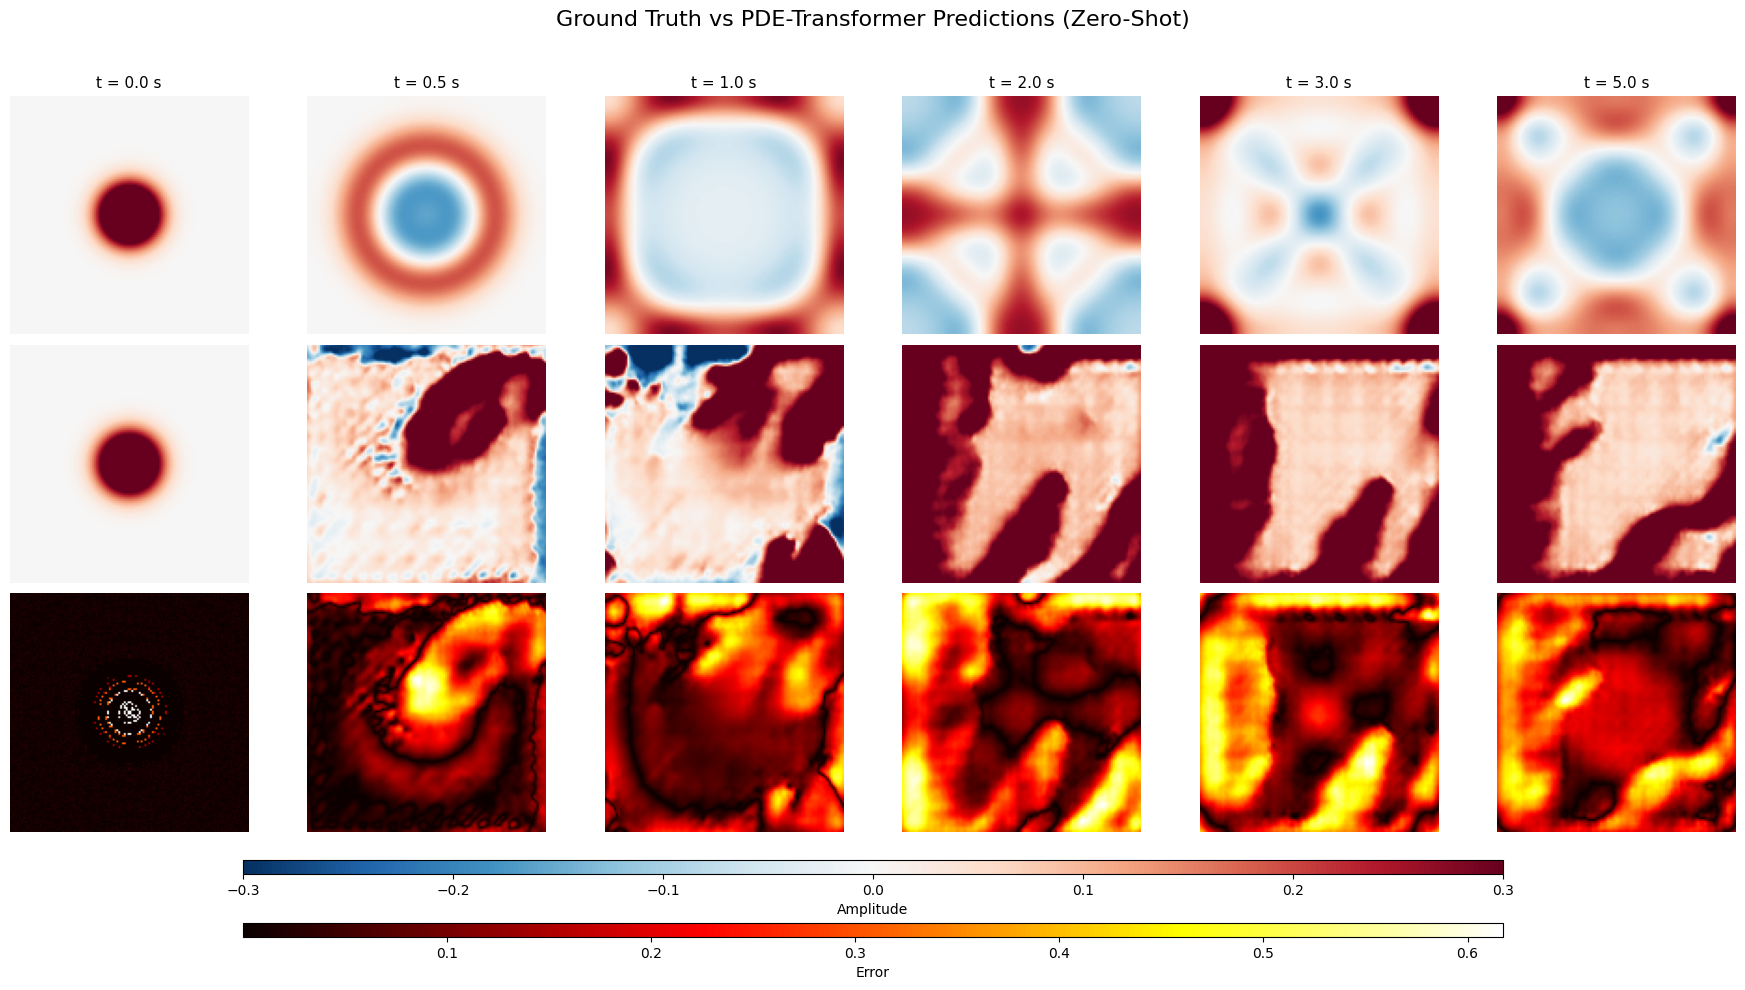

In [28]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Plot subplots at key points to compare them
fig, axes = plt.subplots(3, 6, figsize=(18, 9))
times_to_compare = [0.0, 0.5, 1.0, 2.0, 3.0, 5.0]

# Find common color scale
# vmin = min(gt_downsampled.min(), model_predictions.min())
# vmax = max(gt_downsampled.max(), model_predictions.max())

vmin = -0.3 # causes saturation but shows details better
vmax = 0.3 # causes saturation but shows details better

for col, t in enumerate(times_to_compare):
    idx = int(t / DT_MODEL)
    if idx >= len(model_predictions):
        idx = len(model_predictions) - 1

    # Ground truth
    im = axes[0, col].imshow(gt_downsampled[idx], cmap='RdBu_r',
                              vmin=vmin, vmax=vmax, origin='lower')
    axes[0, col].set_title(f't = {t:.1f} s', fontsize=11)
    axes[0, col].axis('off')
    if col == 0:
        axes[0, col].set_ylabel('Ground Truth', fontsize=12, rotation=0,
                                 ha='right', va='center')

    # Model prediction
    axes[1, col].imshow(model_predictions[idx], cmap='RdBu_r',
                        vmin=vmin, vmax=vmax, origin='lower')
    axes[1, col].axis('off')
    if col == 0:
        axes[1, col].set_ylabel('Model Prediction', fontsize=12, rotation=0,
                                 ha='right', va='center')

    # Error
    error = np.abs(gt_downsampled[idx] - model_predictions[idx])
    im_err = axes[2, col].imshow(error, cmap='hot', origin='lower')
    axes[2, col].axis('off')
    if col == 0:
        axes[2, col].set_ylabel('Absolute Error', fontsize=12, rotation=0,
                                 ha='right', va='center')

plt.suptitle('Ground Truth vs PDE-Transformer Predictions (Zero-Shot)',
             fontsize=16, y=0.98)

# Adjust layout to make room for colorbars
plt.tight_layout(rect=[0, 0.05, 1, 0.96])

# Add colorbars at the bottom
cbar_ax1 = fig.add_axes([0.15, 0.02, 0.7, 0.015])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax1, orientation='horizontal', label='Amplitude')

cbar_ax2 = fig.add_axes([0.15, -0.05, 0.7, 0.015])
fig.colorbar(im_err, cax=cbar_ax2, orientation='horizontal', label='Error')

plt.show()